Universidad Galileo  
Maestría en Data Science  
Statistical Learning I
Sección U  


   # **Tarea 2: Parte 1 - Modelo exponencial de Covid-19**


<p style="text-align: right;">
Henry Giovanni<br/>
Barrientos García<br/>
21001538<br/>
Guatemala, 06 de junio de 2022<br/>
</p>

## Descripción

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


AttributeError: module 'tensorflow._api.v1.compat.v1.compat' has no attribute 'v1'

## Preparación y exploración de los datos

In [2]:
# Obtención de datos
dtCovid = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dtCovid

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/13/22,6/14/22,6/15/22,6/16/22,6/17/22,6/18/22,6/19/22,6/20/22,6/21/22,6/22/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,181120,181178,181236,181465,181534,181574,181666,181725,181808,181912
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,276731,276821,276821,276821,277141,277141,277409,277444,277663,277940
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,265937,265943,265952,265964,265968,265971,265975,265985,265993,266006
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,43224,43224,43449,43449,43449,43449,43449,43449,43449,43774
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,99761,99761,99761,99761,99761,99761,99761,99761,99761,99761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,657879,657879,658100,658100,658100,658100,658100,658503,658503,658503
281,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
282,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11822,11822,11822,11822,11823,11823,11823,11823,11824,11824
283,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,323283,323337,323654,323654,324025,324025,324288,324344,324558,324558


Se puede observar que las fechas están como columnas y están incluidas las del año 2020 hasta la fecha (2022). Para este análisis se tomarán los datos del año 2020.

In [3]:
# Filtrado y transformación de datos
dtCovidGT = dtCovid.drop(['Lat','Long'], axis = 1)
dtCovidGT = dtCovidGT.melt(id_vars=['Country/Region','Province/State'])
dtCovidGT = dtCovidGT[dtCovidGT['Country/Region'] == 'Guatemala']
dtCovidGT.rename(columns = {'variable':'fecha', 'value':'confirmados'}, inplace = True)
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados
139,Guatemala,NaN,1/22/20,0
424,Guatemala,NaN,1/23/20,0
709,Guatemala,NaN,1/24/20,0
994,Guatemala,NaN,1/25/20,0
1279,Guatemala,NaN,1/26/20,0


In [4]:
# Convertimos la fecha (str) a tipo de dato date
dtCovidGT['fecha'] = pd.to_datetime(dtCovidGT['fecha'],infer_datetime_format = True)
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados
139,Guatemala,NaN,2020-01-22,0
424,Guatemala,NaN,2020-01-23,0
709,Guatemala,NaN,2020-01-24,0
994,Guatemala,NaN,2020-01-25,0
1279,Guatemala,NaN,2020-01-26,0


**Nota**: Luego de un análisis exploratorio de los datos se pudo observar que durante los años 2021 y 2022 los casos confirmados con Covid seguían una tendencia constante y a la baja, por lo cual no generaba mayor relevancia realizar predicciones sobre el conjunto de datos de ésos años en particular, por lo cual se tomaron los datos del año 2020 ya que la tendencia es creciente (debido al inicio del evento) por lo cual se puede realizar **un modelo exponencial** de forma más adecuada y para ejemplificar mejor el ejercicio.

In [5]:
# Seleccionando fechas entre enero y diciembre y casos confirmados
dtCovidGT = dtCovidGT[(dtCovidGT['fecha'] > '2020-01-31') &
                      (dtCovidGT['fecha'] <= '2020-12-31') &
                      (dtCovidGT['confirmados'] > 0)]
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados
14959,Guatemala,NaN,2020-03-14,1
15244,Guatemala,NaN,2020-03-15,1
15529,Guatemala,NaN,2020-03-16,2
15814,Guatemala,NaN,2020-03-17,6
16099,Guatemala,NaN,2020-03-18,6


In [6]:
# Conversión de cada fecha a un numero
dtCovidGT['no_dia'] = np.linspace(start = 0,
                                 stop = len(dtCovidGT['fecha']),
                                 num = len(dtCovidGT['fecha']),
                                 dtype = int)
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados,no_dia
14959,Guatemala,NaN,2020-03-14,1,0
15244,Guatemala,NaN,2020-03-15,1,1
15529,Guatemala,NaN,2020-03-16,2,2
15814,Guatemala,NaN,2020-03-17,6,3
16099,Guatemala,NaN,2020-03-18,6,4


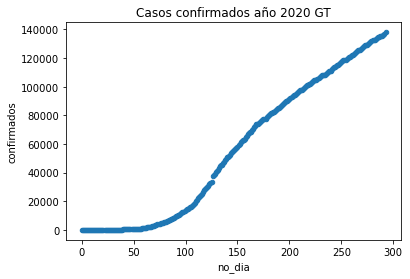

In [7]:
# Revisión de los resultados para ver la tendencia de confirmados
dtCovidGT.plot.scatter(x = 'no_dia', y = 'confirmados')
plt.title('Casos confirmados año 2020 GT')
plt.show()

Para la creación de un modelo exponencial es necesario cambiar la escala de los valores de confirmados y convertirlos a logaritmo

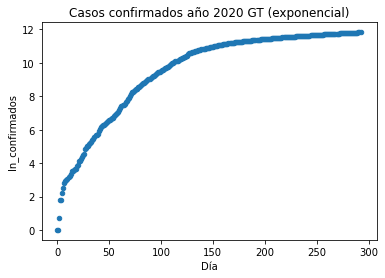

In [8]:
dtCovidGT["ln_confirmados"] = np.log(dtCovidGT['confirmados'])
dtCovidGT.plot.scatter(x = 'no_dia', y = 'ln_confirmados')
plt.title('Casos confirmados año 2020 GT (exponencial)')
plt.xlabel('Día')
plt.show()

## Modelo de regresión lineal

Como parte de la reutilización de herramientas, a continuación hacemos uso de los aprendido en el laboratorio 1, para implementar un modelo de regresión lineal basado en gradient descent con tensorflow.

In [9]:
class MRL:

    def __init__ (self):
        self.parameters = tf.get_variable("parametros", dtype = tf.float32, shape = [1,2], initializer = tf.zeros_initializer())
    
    def gradient_descent(self, x, y, lr):
        mse = 1/2 * tf.reduce_mean(tf.math.square(y - tf.matmul(self.parameters,x)))
        error_summary = tf.summary.scalar("mse_summary", mse)
        gradient = tf.gradients(mse, [self.parameters])
        new_w = tf.assign(self.parameters, self.parameters - lr * gradient[0])
        return new_w, mse, error_summary


In [10]:
def training_model(x, y, lr, epochs, printl):
    # Experimento
    string = './logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_epochs=" + str(epochs) + "_lr=" + str(lr)

    graph = tf.Graph()
    with graph.as_default():
        
        # Creación de los tensores input
        tx = tf.placeholder(tf.float32, [2,None], "tx")
        ty = tf.placeholder(tf.float32, [None], "ty")
        
        # Creación del nodo para el cálculo de los nuevos parámetros según gradient_descent
        mrl = MRL()
        new_parameters = mrl.gradient_descent(tx, ty, lr)
        
        writer = tf.summary.FileWriter(string, graph)
        
        # Ejecución del grafo
        with tf.train.MonitoredSession() as session:
            # Paso de valores a los tensores input
            tensor_dict = {tx:x, ty:y}
            for i in range(epochs + 1):
                # Entrenamiento del modelo para cálculo de los nuevos parámetros
                entrenamiento = session.run(new_parameters, feed_dict = tensor_dict)
                # Imprimiendo los epoch según el printl
                if (i % printl == 0):
                    parametros = session.run(mrl.parameters, feed_dict = tensor_dict)

                    writer.add_summary(entrenamiento[2], i)
                    print("Epoch: ", i, "Parámetros: ", parametros, "mse: ", entrenamiento[1])
                    
            writer.close()
    return entrenamiento

### Experimentos

In [11]:
# Se define X y Y para entrenar modelo
x = dtCovidGT['no_dia']
# Es necesario agregar un 1 a x para poder iniciar los cálculos del gradiente descent
x = np.array([x, np.ones_like(x)], dtype = "float64")
y = dtCovidGT['ln_confirmados']

In [12]:
# Iteración de experimento 01
training_model(x, y, 0.01, 1000, 100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[15.944151    0.09505626]] mse:  49.03856
Epoch:  100 Parámetros:  [[nan nan]] mse:  nan
Epoch:  200 Parámetros:  [[nan nan]] mse:  nan
Epoch:  300 Parámetros:  [[nan nan]] mse:  nan
Epoch:  400 Parámetros:  [[nan nan]] mse:  nan
Epoch:  500 Parámetros:  [[nan nan]] mse:  nan
Epoch:  600 Parámetros:  [[nan nan]] mse:  nan
Epoch:  700 Parámetros:  [[nan nan]] mse:  nan
Epoch:  800 Parámetros:  [[nan nan]] mse:  nan
Epoch:  900 Parámetros:  [[nan nan]] mse:  nan
Epoch:  1000 Parámetros:  [[nan nan]] mse:  nan


(array([[nan, nan]], dtype=float32),
 nan,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\xc0\xff')

In [13]:
# Iteración de experimento 02
training_model(x, y, 0.01, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[15.944151    0.09505626]] mse:  49.03856
Epoch:  10 Parámetros:  [[5.3714129e+25 2.7544664e+23]] mse:  inf
Epoch:  20 Parámetros:  [[nan nan]] mse:  nan
Epoch:  30 Parámetros:  [[nan nan]] mse:  nan
Epoch:  40 Parámetros:  [[nan nan]] mse:  nan
Epoch:  50 Parámetros:  [[nan nan]] mse:  nan
Epoch:  60 Parámetros:  [[nan nan]] mse:  nan
Epoch:  70 Parámetros:  [[nan nan]] mse:  nan
Epoch:  80 Parámetros:  [[nan nan]] mse:  nan
Epoch:  90 Parámetros:  [[nan nan]] mse:  nan
Epoch:  100 Parámetros:  [[nan nan]] mse:  nan


(array([[nan, nan]], dtype=float32),
 nan,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\xc0\xff')

In [14]:
# Iteración de experimento 03
training_model(x, y, 0.001, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[1.5944152  0.00950563]] mse:  49.03856
Epoch:  10 Parámetros:  [[3.7678765e+14 1.9321710e+12]] mse:  2.6779348e+30
Epoch:  20 Parámetros:  [[9.2282115e+28 4.7322362e+26]] mse:  inf
Epoch:  30 Parámetros:  [[nan nan]] mse:  nan
Epoch:  40 Parámetros:  [[nan nan]] mse:  nan
Epoch:  50 Parámetros:  [[nan nan]] mse:  nan
Epoch:  60 Parámetros:  [[nan nan]] mse:  nan
Epoch:  70 Parámetros:  [[nan nan]] mse:  nan
Epoch:  80 Parámetros:  [[nan nan]] mse:  nan
Epoch:  90 Parámetros:  [[nan nan]] mse:  nan
Epoch:  100 Parámetros:  [[nan nan]] mse:  nan


(array([[nan, nan]], dtype=float32),
 nan,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\xc0\xff')

In [15]:
# Iteración de experimento 04
training_model(x, y, 0.0001, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[0.15944152 0.00095056]] mse:  49.03856
Epoch:  10 Parámetros:  [[47.921124    0.24720219]] mse:  9558434.0
Epoch:  20 Parámetros:  [[22147.988     113.57792]] mse:  2046512500000.0
Epoch:  30 Parámetros:  [[10248194.       52552.844]] mse:  4.3817002e+17
Epoch:  40 Parámetros:  [[4.7419996e+09 2.4317018e+07]] mse:  9.381468e+22
Epoch:  50 Parámetros:  [[2.1941959e+12 1.1251862e+10]] mse:  2.008625e+28
Epoch:  60 Parámetros:  [[1.0152879e+15 5.2064069e+12]] mse:  4.3005734e+33
Epoch:  70 Parámetros:  [[4.6978964e+17 2.4090869e+15]] mse:  inf
Epoch:  80 Parámetros:  [[2.1737883e+20 1.1147209e+18]] mse:  inf
Epoch:  90 Parámetros:  [[1.0058453e+23 5.1579874e+20]] mse:  inf
Epoch:  100 Parámetros:  [[4.6542012e+25 2.3866794e+23]] mse:  inf


(array([[4.6542012e+25, 2.3866794e+23]], dtype=float32),
 inf,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\x80\x7f')

In [16]:
# Iteración de experimento 05
model_params = training_model(x, y, 0.00007, 400000, 50000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[0.11160906 0.00066539]] mse:  49.03856
Epoch:  50000 Parámetros:  [[0.04012698 3.0952637 ]] mse:  1.4840043
Epoch:  100000 Parámetros:  [[0.03354119 4.3795676 ]] mse:  0.9827124
Epoch:  150000 Parámetros:  [[0.03080897 4.9123707 ]] mse:  0.8964009
Epoch:  200000 Parámetros:  [[0.02967542 5.1334233 ]] mse:  0.8815309
Epoch:  250000 Parámetros:  [[0.02920408 5.2253385 ]] mse:  0.8789623
Epoch:  300000 Parámetros:  [[0.0290188 5.261468 ]] mse:  0.8785341
Epoch:  350000 Parámetros:  [[0.02893852 5.2771177 ]] mse:  0.87845033
Epoch:  400000 Parámetros:  [[0.02893852 5.2771177 ]] mse:  0.87845033


Despues de la experimentación realizada con los datos obtenidos y transformados, podemos concluir que los mejores datos para definir un modelo y sus parámetros, son los definidos por los valores de: **lr = 0.00007** y **epochs = 400000**. Los parámetros son los definidos a continuación:

In [17]:
# Modelo
print('w = ', model_params[0][0][0])
print('b = ', model_params[0][0][1])
print('h(x) = ', model_params[0][0][0], 'x +', model_params[0][0][1])

w =  0.02893852
b =  5.2771177
h(x) =  0.02893852 x + 5.2771177


In [18]:
# Cálculo de predicciones
predicciones = model_params[0][0][0] * dtCovidGT['no_dia'] + model_params[0][0][1]

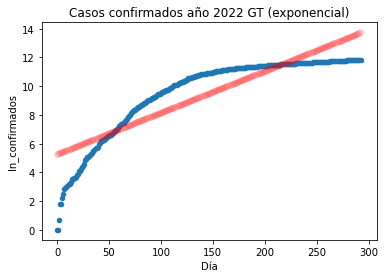

In [19]:
# Visualizando el conjunto original vs las predicciones (exponencial)
dtCovidGT.plot.scatter(x = 'no_dia', y = 'ln_confirmados')
plt.scatter(x = dtCovidGT['no_dia'], y = predicciones, color = 'red', alpha = 0.1)
plt.title('Casos confirmados año 2022 GT (exponencial)')
plt.xlabel('Día')
plt.show()

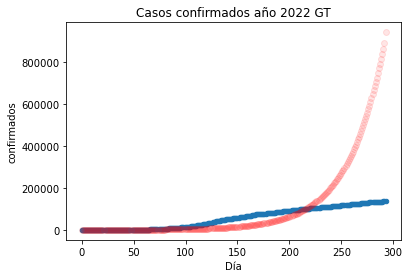

In [20]:
# Visualizando el conjunto original vs las predicciones (sin exponencial)
dtCovidGT.plot.scatter(x = 'no_dia', y = 'confirmados')
plt.scatter(x = dtCovidGT['no_dia'], y = np.exp(predicciones), color = 'red', alpha = 0.1)
plt.title('Casos confirmados año 2022 GT')
plt.xlabel('Día')
plt.show()

**Nota:** para la predicción del día 30 de mayo, se establece que el número de día a partir del día **0 es el 442**

In [21]:
# Calculando predicciones para 30 de mayo
rango = np.linspace(0, 442, 442)
predicciones_may = model_params[0][0][0] * np.exp(rango) + model_params[0][0][1]

predicciones_may[-1]

2.6280724163587114e+190

### Conclusiones

1. Basados en el análisis de los datos seleccionados del año 2020, es visible una clara tendencia no lineal, por lo cual predecir datos a través del establecimiento de un modelo de regresión lineal no es la mejor solución.

2. El mejor modelo dimensional es el **h(x) =  0.02893852 x + 5.2771177** con lr =0.00007 y epoch = 400000

3. Extendiendo el primer punto, observamos que al verificar la curva de predicciones comparada con los datos originales es claro que las predicciones siguen una distribución distinta a los datos originales, por lo tanto éste no es el mejor modelo para predecir la cantidad de persona confirmadas de covid en Guatemala.

4. De los datos análizados observamos que los casos confirmados de Covid-19 entre el 2020 y 2021 siguen distribuciones diferentes, dado esto, podemos decir que predecir datos para el año actual con datos de años anteriores quizá no sea la mejor opción.

5. Según el modelo la predicción de infectados para el 30 de mayo es 2.6280724163587114e+190, que a simple vista es un número sin sentido tomando en cuenta la cantidad de población de nuestro país.